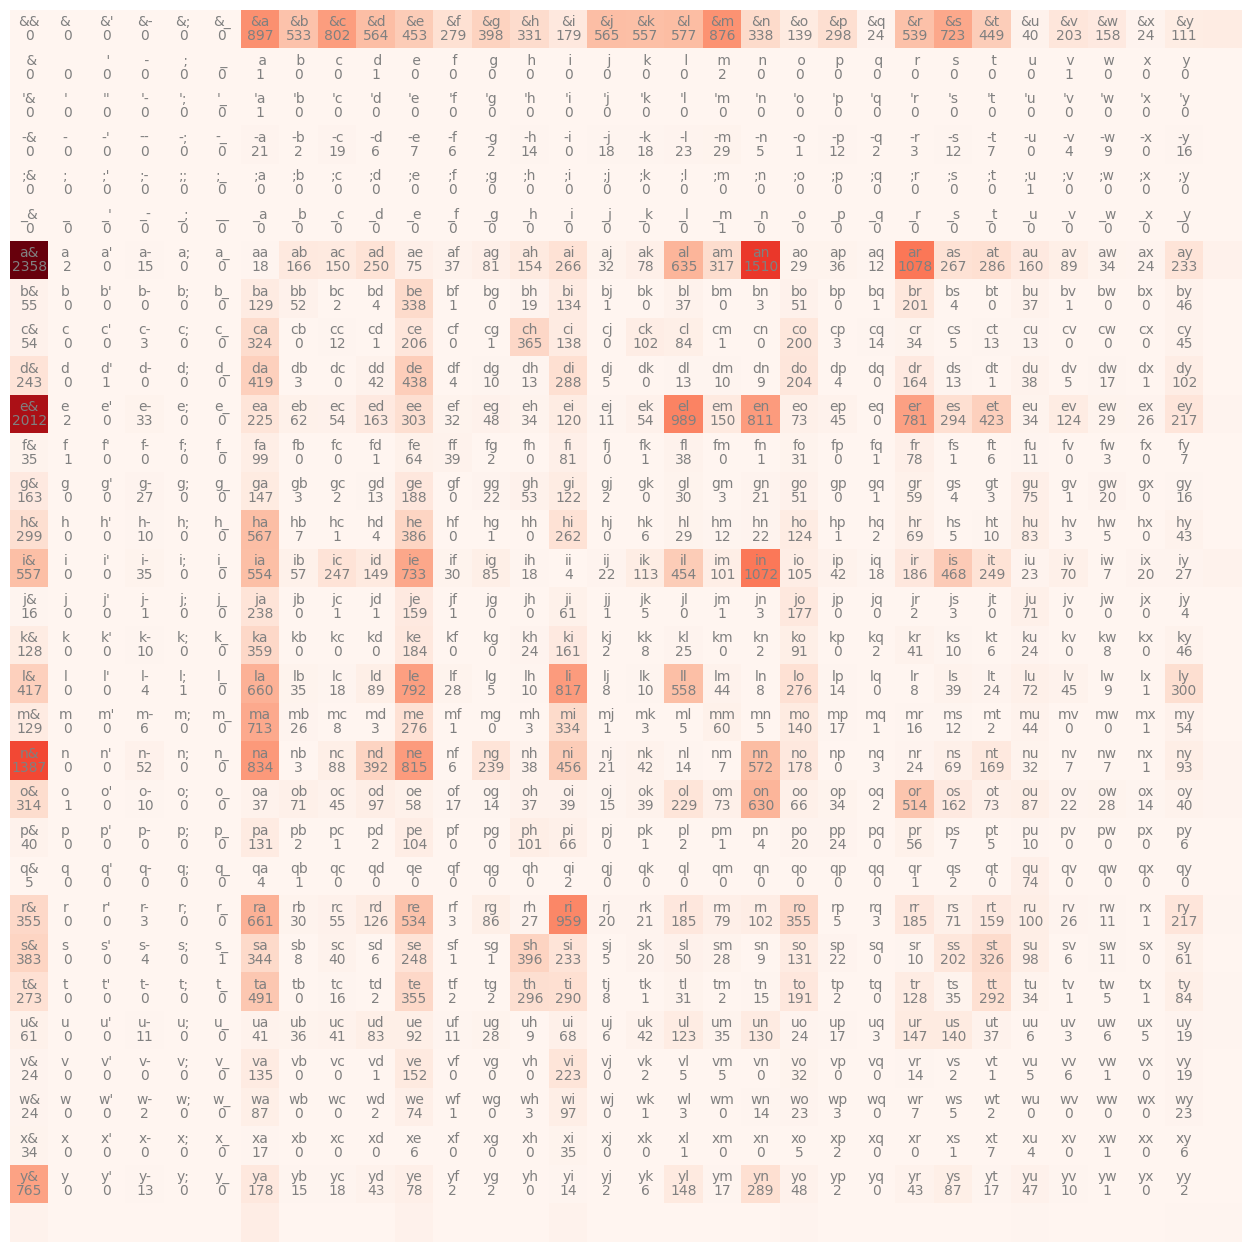

In [3]:
import torch


words = open('names.txt', 'r').read().splitlines()

b = {} # empty dictionary
for w in words:
  chs = ['<S>'] + list(w) + ['<E>'] # ['<S>', 'e', 'm', 'm', 'a', '<E>'] <S> and <E> stand in as markers for start and end of a name
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2) # ie ('<S>', 'e'), ('e', 'm')... etc
    b[bigram] = b.get(bigram, 0) + 1 # if bigram is already present in the dictionary, increment the count (value) of the bigram key by 1, if not, add the bigram as a key and assign the value as 1

sorted_array = sorted(b.items(), key = lambda kv: -kv[1]) # this sorts the dictionary into a list of the most frequent bigrams

# Now we want to construct a matrix whre the columns are the second character and the rows are the first character for all possible bigrams, and the cells in the middle show the frequency of each bigram
# Bring in pytorch

# we want a 33 x 33 array because we have the 26 alphabet letters, a few special characters and <S> and <E>
N = torch.zeros((32, 32), dtype = torch.int32)

# we need to convert all the characters in the possible bigrams (a-z, special characters and <S> and <E>) into integers so that our matrix is comprised of only integers
chars = sorted(list(set(''.join(words)))) #lists all the unique characters in our names (it's just the lowercase alphabet + a few special characters)
stoi = {s:i+1 for i,s in enumerate(chars)} # this creates a dictionary of values assigned to the characters (0-25)
stoi['&'] = 0 # adding key-value pair to represent the start or end
itos = {i:s for s,i in stoi.items()} # constructing a reverse dictionary to convert integers to characters

for w in words:
  chs = ['&'] + list(w) + ['&']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1] # convert the first character in the bigram to its corresponding integer code
    ix2 = stoi[ch2] # convert the second character in the bigram to its corresponding integer code
    N[ix1, ix2] += 1 # in the 33x33 array we are going to increment the count-cell responsible for this bigram by 1, ix1 is both the code for the character and the row/column number in the 33x33 array, as {a: 5, b: 6, .. etc} and a is also the [5] row/column, so this works


import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Reds')
for i in range(0, 31):
    for j in range(0, 31):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='grey')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='grey')
plt.axis('off');

In [4]:
# The +1 here adds smoothing, meaning no bigrams have 0 instances, this prevents 0% probabilities which are undesirable apparently
P = (N+1).float()
# this cretes a column vector representing the sum of each row from the matrix N
# We will use this to normalise the entire matrix N into a probability distribution
Psum = P.sum(1, keepdim=True)
P /= Psum
# So P is our 32x32 matrix of bigram normalised probabilities, each row sums to 1

# generator makes our sampling deterministic but still random, so we can recreate it the same every time
g = torch.Generator().manual_seed(21474833647)

# This loop samples from the newly created probability distribution matrix P according to the probabilities
# It finishes sampling when it reaches an end character and outputs the result
for i in range(20):
    ix = 0
    out=[]
    while True:
        ix = torch.multinomial(P[ix], num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            break
        out.append(itos[ix])
    print(''.join(out))

sedrenelalliu-_y
g
dattye
kariparie
ga
arnesarssmuielyamarallistinshissata
geta
la
mon
s
sick
fe
tieknena
meelieto
reninele
eavigcodera
leronerelle
ta
bfaclerla
werie


In [4]:
# In this block we are starting to calculate the performance of our model
# Generally speaking, we are rating how likely bigrams that exist in our training data are 
# to be predicted by our model.

# prob = probability, logprob = log of this (helps with summing total probabilities)
# log_likelihood = sum of all logs, nll = negative log_likelihood (so we can aim to minimise this)
# mnll = mean negative log_likelihood. This is out loss measurement we want to minimise

# This is the loss function
log_likelihood = 0
n = 0
for w in words:
# for w in ['maasxe']:
  chs = ['&'] + list(w) + ['&']
  for ch1, ch2 in zip(chs, chs[1:]):
    n+=1
    ix1 = stoi[ch1] # convert the first character in the bigram to its corresponding integer code
    ix2 = stoi[ch2] # convert the second character in the bigram to its corresponding integer code
    prob = P[ix1, ix2] # Probability of this bigram as predicted by our model
    logprob = torch.log(prob).item()
    log_likelihood += logprob
    # print(ch1, ch2, prob.item(), logprob)

nll = -log_likelihood
mnll = nll / n
# For our entire model, the mnll is currenrtly 2.47 when measured against the training data
print(mnll)

2.474670513375932


In [49]:
# Now that we have this loss function, we want to make a neural net to predict new names, which we can rate against
# Our loss function

# To do this we need a training set, made up of the inputs and the targets. The inputs(xs) are the first character of
# Every bigram, and the targets(ys)  are the second character of every bigram.

xs, ys = [], []
for w in words[:1]:
  chs = ['&'] + list(w) + ['&']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1] # convert the first character in the bigram to its corresponding integer code
    ix2 = stoi[ch2] # convert the second character in the bigram to its corresponding integer code
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

# xs is just a list of every character in the training set (integerized), ys is this same list offset by 1
# So for each integer in xs (which corresponds to a letter), we want our model to assign a high probability that the next
# character will be the one that matches the corresponding integer from ys
# xs[0] should highly predict ys[0] and xs[1] should highly predict ys[1] etc. all the way through the training set.

In [7]:
# We can't feed the integers in xs directly into a neural network, so we need to encode them (one hot)
# One hot encoding takes each integer and turns it into a tensor of length 32, with all values 0 except for the value at
# index integer, which is a 1 (this is better for the later neural network multiplications)
import torch.nn.functional as F
x_encoded = F.one_hot(xs, num_classes=32).float()

In [8]:
g = torch.Generator().manual_seed(218)
W = torch.randn((32,32), generator = g, requires_grad=True) # 32 random initial weights for our 32 neurons
# @ symbol is a matrix multiplication, which below dot products (element wise multiplication and then sum) every character 
# integer tensor (nx32) in xs by every row of the 32x32 tensor of random weights. We end up with a n x 32 tensor where n 
# is the number of characters in our training set This nx32 tensor shows the activations of our 32 neurons on all of the xs.
x_encoded @ W 
# so for each row from the inputs xs (n) we have 32 activations, one for each neuron. Each character gets 32 activations, each
# representing the likelihood of the next character, e.g. the 32nd activation of the character e is the probability it'll be followed by a z

tensor([[-0.7021, -1.4978,  0.2911,  ..., -0.3953, -0.4913, -0.7081],
        [ 0.0699,  1.1637,  0.8352,  ..., -0.3850, -1.3822, -0.5213],
        [ 0.0699,  1.1637,  0.8352,  ..., -0.3850, -1.3822, -0.5213],
        ...,
        [-1.3381,  1.2172,  0.6111,  ...,  0.0864,  0.6778,  1.5764],
        [ 0.2225, -0.5585, -0.2506,  ...,  1.5140, -0.7702,  1.6123],
        [ 0.2505,  0.0609, -0.8362,  ..., -1.1064,  0.4297,  0.1955]],
       grad_fn=<MmBackward0>)

In [52]:
# Now we want to convert these into probabilities like we had before in our non-neural model
# at the moment we can treat the above activations as equivelant to log counts (counts from the original bigram matrix N)
# to make them probabilities, we take the exponent to remove the log (and make everything positive)
# The normalize by dividing each row by its sum.

logits = x_encoded @ W # log counts are called logits
# The next two lines are what's called a softmax, converting the log counts to prob distributions
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
probs[0]

tensor([0.0124, 0.0056, 0.0335, 0.0760, 0.0655, 0.1438, 0.0130, 0.0487, 0.0746,
        0.0281, 0.0169, 0.0534, 0.0093, 0.0284, 0.0293, 0.0088, 0.0058, 0.0282,
        0.0255, 0.0085, 0.0323, 0.0445, 0.0617, 0.0038, 0.0195, 0.0150, 0.0043,
        0.0195, 0.0395, 0.0169, 0.0153, 0.0123], grad_fn=<SelectBackward0>)

In [104]:
# Randomly creating our initial weights before backpropagating
g = torch.Generator().manual_seed(218)
W = torch.randn((32,32), generator = g, requires_grad=True)

In [108]:
# The following is a reapeat of some of the code above, which represents a full forward pass of the neural net
x_encoded = F.one_hot(xs, num_classes=32).float()
logits = x_encoded @ W # log counts are called logits
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
# the next line shows the probabilities of the first 8 characters from ys from being predicted from the first 8 characters of xs
prediction_tensor = probs[torch.arange(8), ys]
# then this is the meaan negative log likelihood, or the loss score
mnll = -prediction_tensor.log().mean()

loss = mnll
loss.item()

3.8909754753112793

In [106]:
# Now time for a backward pass
W.grad = None # zero the gradient
loss.backward() # this backwards pass will figure out the gradients of each of the weights (activations) in W

In [107]:
W.data += -0.1 * W.grad # this updates the weights based off the gradient (positive gradient is bad so we do -0.1 * grad)

In [5]:
# Putting everything together

# Create the dataset
xs, ys = [], []
for w in words:
  chs = ['&'] + list(w) + ['&']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1] # convert the first character in the bigram to its corresponding integer code
    ix2 = stoi[ch2] # convert the second character in the bigram to its corresponding integer code
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

# Initialize the network by creating randomly generated weights for the neurons
g = torch.Generator().manual_seed(218)
W = torch.randn((32,32), generator = g, requires_grad=True)

In [9]:
# Forward pass
for k in range(10): 
    x_encoded = F.one_hot(xs, num_classes=32).float()
    logits = x_encoded @ W # log counts are called logits
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    # the next line shows the probabilities of the first 8 characters from ys from being predicted from the first 8 characters of xs
    prediction_tensor = probs[torch.arange(num), ys]
    # then this is the meaan negative log likelihood, or the loss score
    mnll = -prediction_tensor.log().mean()
    loss = mnll
    print(loss.item())

    # Backward pass
    W.grad = None # zero the gradient
    loss.backward()
    
    #update the weights with the gradient
    W.data += -100 * W.grad 

3.91383957862854
3.294036626815796
3.070953130722046
2.9437813758850098
2.884965419769287
2.7914106845855713
2.761367082595825
2.7190990447998047
2.720658302307129
2.670767307281494


In [10]:
# To sample from the neural model

g = torch.Generator().manual_seed(218)

for i in range(5):

    out = []
    ix = 0
    x_encoded = F.one_hot(xs, num_classes=32).float()
    logits = x_encoded @ W # log counts are called logits
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)

In [154]:
# To sample from the neural model
g = torch.Generator().manual_seed(214748336473)

# Sample in the same way as before but from probs rather than p
for i in range(20):
    ix = 0
    out=[]
    while True:
        ix = torch.multinomial(probs[ix], num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            break
        out.append(itos[ix])
    print(''.join(out))

wniamctijwb
sanonyrnaiernenonih
mnenilalah
dlaldmr
g
cidgcpardnyolab
atmva
saccdlig
ovwnitnh
g
snercadknilobtnanetkmlay
knij
qrmauniliamsanonikrh
sibasrlyionitcknrlon
anrrrrnajhin
mejrrbanenanarnq
kimg
sicohzonedn
lihnpaneruaienoreyanaleyernab
hydrrl
